# Project IV. Scene recognition with bag of words

1. Tiny image features and nearest neighbor classifier  
2. Bag of word features and nearest neighbor classifier  
3. Bag of word features and linear SVM classifier  

Your need complete following functions:  
    get_tiny_images, build_vocabulary, get_bags_of_words, svm_classify, nearest_neighbor_classify  
1. Tiny + KNN (get_tiny_images, nearest_neighbor_classify)  
2. BOW + KNN (build_vocabulary, get_bags_of_words, nearest_neighbor_classify)  
3. BOW + SVM (build_vocabulary, get_bags_of_words, nearest_neighbor_classify)  

For feature extractor and SVM, using sklearn and skimage is acceptable.

The starter code is initialized to 'placeholder' just so that the starter code does not crash when run unmodified and you can get a preview of how results are presented.

    Interpreting your performance with 100 training examples per category:
     accuracy  =   0 -> Something is broken.
     accuracy ~= .07 -> Your performance is equal to chance.
                        Something is broken or you ran the starter code unchanged.
     accuracy ~= .20 -> Rough performance with tiny images and nearest
                        neighbor classifier. Performance goes up a few
                        percentage points with K-NN instead of 1-NN.
     accuracy ~= .20 -> Rough performance with tiny images and linear SVM
                        classifier. Although the accuracy is about the same as
                        nearest neighbor, the confusion matrix is very different.
     accuracy ~= .40 -> Rough performance with bag of word and nearest
                        neighbor classifier. Can reach .60 with K-NN and
                        different distance metrics.
     accuracy ~= .50 -> You've gotten things roughly correct with bag of
                        word and a linear SVM classifier.
     accuracy >= .70 -> You've also tuned your parameters well. E.g. number
                        of clusters, SVM regularization, number of patches
                        sampled when building vocabulary, size and step for
                        dense features.
     accuracy >= .80 -> You've added in spatial information somehow or you've
                        added additional, complementary image features. This
                        represents state of the art in Lazebnik et al 2006.
     accuracy >= .85 -> You've done extremely well. This is the state of the
                        art in the 2010 SUN database paper from fusing many
                        features. Don't trust this number unless you actually
                        measure many random splits.
     accuracy >= .90 -> You used modern deep features trained on much larger
                        image databases.
     accuracy >= .96 -> You can beat a human at this task. This isn't a
                        realistic number. Some accuracy calculation is broken
                        or your classifier is cheating and seeing the test
                        labels.

# Step 0: Set up parameters, category list, and image paths.
Uncomment various feature and classifier combinations to test them.

In [1]:
import numpy as np
import os

from helpers import get_image_paths
from student import get_tiny_images, build_vocabulary, get_bags_of_words, svm_classify, nearest_neighbor_classify
from create_results_webpage import create_results_webpage

In [2]:
# FEATURE = 'tiny image'
FEATURE = 'bag of words'
# FEATURE = 'placeholder'

# CLASSIFIER = 'nearest neighbor'
CLASSIFIER = 'support vector machine'
# CLASSIFIER = 'placeholder'

# This is the path the script will look at to load images from.
data_path = '../data/'

# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
       'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
       'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']

# This list of shortened category names is used later for visualization.
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
    'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For']

# Number of training examples per category to use. Max is 100. For
# simplicity, we assume this is the number of test cases per category as
# well.
num_train_per_cat = 100

# This function returns string arrays containing the file path for each train
# and test image, as well as string arrays with the label of each train and
# test image. By default all four of these arrays will be 1500x1 where each
# entry is a string.
print('Getting paths and labels for all train and test data.')
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path, categories, num_train_per_cat)
#   train_image_paths  1500x1   list
#   test_image_paths   1500x1   list
#   train_labels       1500x1   list
#   test_labels        1500x1   list

Getting paths and labels for all train and test data.


# Step 1: Represent each image with the appropriate feature
Each function to construct features should return an N x d matrix, where
N is the number of paths passed to the function and d is the
dimensionality of each image representation. See the starter code for
each function for more details.

In [3]:

print('Using %s representation for images.' % FEATURE)

if FEATURE.lower() == 'tiny image':
    print('Loading tiny images...')
    # YOU CODE get_tiny_images (see student.py)
    train_image_feats = get_tiny_images(train_image_paths)
    test_image_feats  = get_tiny_images(test_image_paths)
    print('Tiny images loaded.')

elif FEATURE.lower() == 'bag of words':
    # Because building the vocabulary takes a long time, we save the generated
    # vocab to a file and re-load it each time to make testing faster. If
    # you need to re-generate the vocab (for example if you change its size
    # or the length of your feature vectors), simply delete the vocab.npy
    # file and re-run main.py
    
    if not os.path.isfile('vocab.npy'):
        print('No existing visual word vocabulary found. Computing one from training images.')
        #Larger values will work better (to a point), but are slower to compute
        vocab_size = 200

        # YOU CODE build_vocabulary (see student.py)
        vocab = build_vocabulary(train_image_paths, vocab_size)
        np.save('vocab.npy', vocab)

    # YOU CODE get_bags_of_words.m (see student.py)
    if not os.path.isfile('train_image_feats.npy'):
        print('No train data.')
        train_image_feats = get_bags_of_words(train_image_paths)
        np.save('train_image_feats.npy', train_image_feats)
    else:
        train_image_feats = np.load('train_image_feats.npy')
    # You may want to write out train_image_features here as a *.npy and
    # load it up later if you want to just test your classifiers without
    # re-computing features
    if not os.path.isfile('test_image_feats.npy'):
        print('No Test data.')
        test_image_feats  = get_bags_of_words(test_image_paths)
        np.save('test_image_feats.npy', test_image_feats)
    else:
        test_image_feats = np.load('test_image_feats.npy')
    # Same goes here for test image features.

elif FEATURE.lower() == 'placeholder':
    train_image_feats = []
    test_image_feats = []
else:
    raise ValueError('Unknown feature type!')

Using bag of words representation for images.


# Step 2: Classify each test image by training and using the appropriate classifier
Each function to classify test features will return an N x 1 string array,
where N is the number of test cases and each entry is a string indicating
the predicted category for each test image. Each entry in
'predicted_categories' must be one of the 15 strings in 'categories',
'train_labels', and 'test_labels'. See the starter code for each function
for more details.

In [4]:
print('Using %s classifier to predict test set categories.' % CLASSIFIER)

if CLASSIFIER.lower() == 'nearest neighbor':
    # YOU CODE nearest_neighbor_classify (see student.py)
    predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

elif CLASSIFIER.lower() == 'support vector machine':
    # YOU CODE svm_classify (see student.py)
    predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)

elif CLASSIFIER.lower() == 'placeholder':
    #The placeholder classifier simply predicts a random category for every test case
    random_permutation = np.random.permutation(len(test_labels))
    predicted_categories = [test_labels[i] for i in random_permutation]

else:
    raise ValueError('Unknown classifier type')

Using support vector machine classifier to predict test set categories.


# Step 3: Build a confusion matrix and score the recognition system
You do not need to code anything in this section.
If we wanted to evaluate our recognition method properly we would train
and test on many random splits of the data. You are not required to do so
for this project.
This function will recreate results_webpage/index.html and various image
thumbnails each time it is called. View the webpage to help interpret
your classifier performance. Where is it making mistakes? Are the
confusions reasonable?

Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 72.000%


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Wrote results page to results_webpage/index.html.


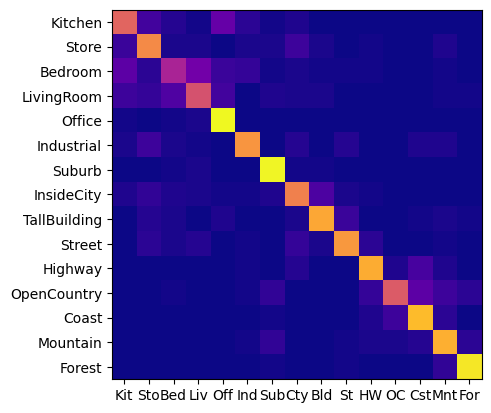

In [5]:
create_results_webpage( train_image_paths, \
                            test_image_paths, \
                            train_labels, \
                            test_labels, \
                            categories, \
                            abbr_categories, \
                            predicted_categories)